# EX4

## Part 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
from scipy.optimize import minimize
from numpy import linalg as LA

input_layer_size = 400 # 20x20 Input Images of Digits
hidden_layer_size = 25 # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

## Visualize data

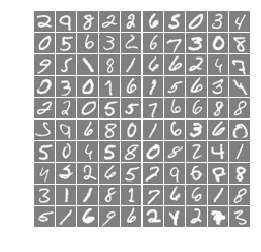

In [2]:
def display_data(x, example_width=None):
    x_size = x.shape
    if example_width is None:
        example_width = int(round(math.sqrt(x_size[1])))
    
    # Compute rows and columns
    example_height = int(x_size[1] / example_width)
    
    # Compute number of items to display
    display_rows = math.floor(math.sqrt(x_size[0]))
    display_cols = math.ceil(x_size[0] / display_rows)
        
    # Betwen image pading
    pad = 1
    
    # Ensure we treat as int values
    display_arr = np.ones((pad + display_rows * (example_height + pad),
                           pad + display_cols * (example_width + pad) ))
        
    curr_ex = 0
    i = 0
    j = 0
    while j < display_rows:
        while i < display_cols:
            if curr_ex > x_size[0]:
                break 
            
            # Copy the patch
            # Get max value of the patch
            max_val = max(abs(x[curr_ex, :]))
            j_idx = pad + (j) * (example_height + pad)
            i_idx = pad + (i) * (example_width + pad)
            tmp = np.reshape(x[curr_ex,:], (example_height, example_width)) / max_val
            display_arr[j_idx + np.r_[range(0, example_height)],
                        i_idx + np.c_[range(0, example_width)]] = tmp
                        
            curr_ex += 1
            i += 1
        j += 1
        i = 0
        if curr_ex > x_size[0]:
            break
    plt.set_cmap('gray') # Use grey colour         
    img = plt.imshow(display_arr, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show()

mat = scipy.io.loadmat('machine-learning-ex4/ex4/ex4data1.mat') # training data
orig_X = mat['X']
orig_Y = mat['y']

random_indices = np.random.randint(0, orig_X.shape[0], size=100)
selection = orig_X[random_indices]

display_data(selection)

## Loading params

In [3]:
print('Loading Saved Neural Network Parameters ...')

# Load the weights into variables Theta1 and Theta2
weights = scipy.io.loadmat('machine-learning-ex4/ex4/ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

# Unroll parameters 
nn_params = np.concatenate((theta1.flatten(), theta2.flatten()), axis=0).reshape(-1,1)

Loading Saved Neural Network Parameters ...


## Compute cost (feed-forward) with regularization

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_p):
    """Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    for our 2 layer neural network"""
    theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    
    # Setup some useful variables
    m = x.shape[0]
    # Add bias term
    x = np.append(np.ones((m, 1)), x, axis=1)
    costs = 0
    for idx in range(m):        
        a1 = x[idx,:].reshape(-1,1)
        z2 = sigmoid(theta1@a1)
        a2 = np.append(np.ones((1, z2.shape[1])), z2, axis=0)
        z3 = sigmoid(theta2@a2)
        
        # Create Y matrix
        y_val = y[idx,:]
        y_i = np.zeros((1, num_labels))
        y_i[0][y_val - 1] = 1
        p_cost = (1.0 * y_i)@np.log(z3) + (1.0 - y_i)@np.log(1 - z3)
        
        costs += p_cost
    
    # Skip over first terms!
    cost = (-1 * (1.0 / m)) * np.sum(costs) + \
        ((lambda_p / (2.0 * m)) * (np.sum(np.square(theta1[: ,1:])) + np.sum(np.square(theta2[: ,1:]))))
    
    return cost

print('Feedforward Using Neural Network ...')
# Weight regularization parameter (we set this to 0 here).
lambda_p = 0;
J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, orig_X, orig_Y, lambda_p)
print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('(this value should be about 0.287629)')

print('Checking Cost Function (with Regularization)...')
# Weight regularization parameter (we set this to 1 here).
lambda_p = 1.0
J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, orig_X, orig_Y, lambda_p)
print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('this value should be about 0.383770)')

Feedforward Using Neural Network ...
Cost at parameters (loaded from ex4weights): 0.28762916516131876
(this value should be about 0.287629)
Checking Cost Function (with Regularization)...
Cost at parameters (loaded from ex4weights): 0.3837698590909235
this value should be about 0.383770)


## Sigmoid gradient

In [5]:
def sigmoid_gradient(z):
    t = sigmoid(z)
    return t * (1-t)

print('Evaluating sigmoid gradient...')
init_theta = np.array([[-1], [-0.5], [0], [0.5], [1]])
g = sigmoid_gradient(init_theta)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: {}'.format(g))

Evaluating sigmoid gradient...
Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: [[0.19661193]
 [0.23500371]
 [0.25      ]
 [0.23500371]
 [0.19661193]]


## Random init

In [6]:
def rand_initialize_weights(l_in, l_out, epsilon=0.12):
    w = np.random.uniform(0, 1, (l_out, l_in)) * ((2 * epsilon) - epsilon)
    # Add in bias term
    w = np.append(np.ones((w.shape[0], 1)), w, axis=1)
    return w

print('Initializing Neural Network Parameters ...')
initial_theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate((initial_theta1.flatten(), initial_theta2.flatten()), axis=0).reshape(-1,1)

Initializing Neural Network Parameters ...


## Backpropagation

In [24]:
def nn_backprop_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_p):
    """Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    for our 2 layer neural network"""
    theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    
    # Setup some useful variables
    m = x.shape[0]
    theta1_grad = np.zeros((theta1.shape[0], theta1.shape[1]))
    theta2_grad = np.zeros((theta2.shape[0], theta2.shape[1]))
    costs = 0
    # Add bias term
    x = np.append(np.ones((m, 1)), x, axis=1)

    for idx in range(m):
        a1 = x[idx,:].reshape(-1,1)
        z2 = theta1@a1
        a2 = np.append(np.ones((1, z2.shape[1])), sigmoid(z2), axis=0)
        z3 = theta2@a2
        a3 = sigmoid(z3)
        
        # Create Y matrix
        y_val = y[idx,:]
        y_i = np.zeros((1, num_labels))
        y_i[0][y_val - 1] = 1
        # Calculate the cost
        p_cost = (1.0 * y_i)@np.log(a3) + (1.0 - y_i)@np.log(1 - a3)
        
        # Calculate gradients
        delta3 = a3 - y_i.T
        
        z2t = np.insert(z2, 0, values=np.ones(1)).reshape(-1, 1)
        delta2 = np.multiply((theta2.T@delta3), sigmoid_gradient(z2t))
        delta2 = delta2[1:]
        
        theta1_grad = theta1_grad + delta2@a1.T
        theta2_grad = theta2_grad + delta3@a2.T
             
        costs += p_cost
    # Regularize cost function
    # Skip over first terms!
    cost = (-1.0 * (1.0 / m)) * np.sum(costs) + \
        ((lambda_p / (2.0 * m)) * (np.sum(np.square(theta1[: ,1:])) + np.sum(np.square(theta2[: ,1:]))))
    
    # Add regularization to gradient calc
    theta2_grad = (1.0/m) * theta2_grad
    theta1_grad = (1.0/m) * theta1_grad
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + ((lambda_p / m) * theta2[:,1:])
    theta1_grad[:, 1:] = theta1_grad[:, 1:] + ((lambda_p / m) * theta1[:,1:])
    
    # Unroll gradient parameters
    grad = np.concatenate((np.ravel(theta1_grad), np.ravel(theta2_grad)))
    return cost, grad

def compute_numerical_gradient(input_layer_size, hidden_layer_size, num_labels, x, y, lambda_p, theta):
    numgrad = np.zeros(theta.size).reshape(-1,1)
    perturb = np.zeros(theta.size).reshape(-1,1)
    e = 1.0*(10**-4)
    for p in range(0, theta.size):
        # Set perturbation vector
        perturb[p] = e
        (loss1, grad1) = nn_backprop_cost_function((theta - perturb), input_layer_size, hidden_layer_size, num_labels, x, y, lambda_p)
        (loss2, grad2) = nn_backprop_cost_function((theta + perturb), input_layer_size, hidden_layer_size, num_labels, x, y, lambda_p)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    return numgrad.flatten()

def debug_initialize_weights(fan_out, fan_in):
    # Set W to zeros
    w = np.zeros((fan_out, 1 + fan_in))

    # Initialize W using "sin", this ensures that W is always of the same values and will be useful for debugging
    return np.reshape(np.sin(range(1, np.size(w)+1)), w.shape, order='F') / 10

def check_nn_gradients(lambda_p=0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # We generate some 'random' test data
    theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    theta2 = debug_initialize_weights(num_labels, hidden_layer_size)
    
    # Reusing debug_initialize_weights to generate X
    x = debug_initialize_weights(m, input_layer_size - 1)
    y = 1 + np.mod(range(1, m + 1), num_labels).reshape(-1,1)
    
    # Unroll parameters
    nn_params = np.concatenate((theta1.flatten(), theta2.flatten()), axis=0).reshape(-1,1)
    
    (J, grad) = nn_backprop_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_p)
    numgrad = compute_numerical_gradient(input_layer_size, hidden_layer_size, num_labels, x, y, lambda_p, nn_params)
    
    # Visually examine the two gradient computations. The two columns you get should be very similar.
    print('Numerical Gradient')
    print('{}'.format(numgrad))
    print('Analytical Gradient')
    print('{}'.format(grad))
   
    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = LA.norm(numgrad-grad)/LA.norm(numgrad+grad)

    print('''If your backpropagation implementation is correct, then the relative difference will be small 
(less than 1e-9).''')
    print('Relative Difference: {}'.format(diff))

print('Checking Backpropagation...');
# Check gradients by running check_nn_gradients
check_nn_gradients()

Checking Backpropagation...
Numerical Gradient
[-9.27825235e-03 -3.04978931e-06 -1.75060082e-04 -9.62660618e-05
  8.89911959e-03  1.42869450e-05  2.33146358e-04  1.17982666e-04
 -8.36010761e-03 -2.59383093e-05 -2.87468729e-04 -1.37149709e-04
  7.62813551e-03  3.69883213e-05  3.35320347e-04  1.53247079e-04
 -6.74798369e-03 -4.68759764e-05 -3.76215588e-04 -1.66560297e-04
  3.14544970e-01  1.64090819e-01  1.64567932e-01  1.58339334e-01
  1.51127527e-01  1.49568335e-01  1.11056588e-01  5.75736494e-02
  5.77867379e-02  5.59235296e-02  5.36967009e-02  5.31542052e-02
  9.74006970e-02  5.04575855e-02  5.07530173e-02  4.91620841e-02
  4.71456249e-02  4.65597186e-02]
Analytical Gradient
[-9.27825236e-03 -3.04978914e-06 -1.75060082e-04 -9.62660620e-05
  8.89911960e-03  1.42869443e-05  2.33146357e-04  1.17982666e-04
 -8.36010762e-03 -2.59383100e-05 -2.87468729e-04 -1.37149706e-04
  7.62813551e-03  3.69883234e-05  3.35320347e-04  1.53247082e-04
 -6.74798370e-03 -4.68759769e-05 -3.76215587e-04 -1.66

## Checking backprop

In [25]:
print('Checking Backpropagation (w/ Regularization)...')

weights = scipy.io.loadmat('machine-learning-ex4/ex4/ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

# Unroll parameters 
nn_params = np.concatenate((theta1.flatten(), theta2.flatten()), axis=0).reshape(-1,1)

#  Check gradients by running checkNNGradients
lambda_p = 3.0
check_nn_gradients(lambda_p)

# Also output the costFunction debugging values
debug_J, debug_grad = nn_backprop_cost_function(nn_params, 
                                             input_layer_size, 
                                             hidden_layer_size, 
                                             num_labels, 
                                             orig_X, 
                                             orig_Y, 
                                             lambda_p)

print('Cost at (fixed) debugging parameters (w/ lambda = {0}): {1}'.format(lambda_p, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')


Checking Backpropagation (w/ Regularization)...
Numerical Gradient
[-9.27825235e-03 -1.67679797e-02 -6.01744725e-02 -1.73704651e-02
  8.89911959e-03  3.94334829e-02 -3.19612287e-02 -5.75658668e-02
 -8.36010761e-03  5.93355565e-02  2.49225535e-02 -4.51963845e-02
  7.62813551e-03  2.47640974e-02  5.97717617e-02  9.14587966e-03
 -6.74798369e-03 -3.26881426e-02  3.86410548e-02  5.46101547e-02
  3.14544970e-01  1.18682669e-01  2.03987128e-01  1.25698067e-01
  1.76337550e-01  1.32294136e-01  1.11056588e-01  3.81928689e-05
  1.17148233e-01 -4.07588279e-03  1.13133142e-01 -4.52964427e-03
  9.74006970e-02  3.36926556e-02  7.54801264e-02  1.69677090e-02
  8.61628953e-02  1.50048382e-03]
Analytical Gradient
[-9.27825236e-03 -1.67679797e-02 -6.01744725e-02 -1.73704651e-02
  8.89911960e-03  3.94334829e-02 -3.19612287e-02 -5.75658668e-02
 -8.36010762e-03  5.93355565e-02  2.49225535e-02 -4.51963845e-02
  7.62813551e-03  2.47640974e-02  5.97717617e-02  9.14587966e-03
 -6.74798370e-03 -3.26881426e-02  

## Training NN

In [28]:
print('Training Neural Network...')

# You should also try different values of lambda
lambda_p = 1.0

# Ensure init params set
initial_theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_initialize_weights(hidden_layer_size, num_labels)
# Unroll parameters
initial_nn_params = np.concatenate((initial_theta1.flatten(), initial_theta2.flatten()), axis=0).reshape(-1,1)

# Run minimize
xopt = minimize(nn_backprop_cost_function, initial_nn_params, 
                args=(input_layer_size, hidden_layer_size, num_labels, orig_X, orig_Y, lambda_p), 
                method='L-BFGS-B', 
                jac=True, 
                options={'disp': True, 
                         'gtol': 1e-05, 
                         'maxiter': 200})

cost = xopt.fun
out_params = xopt.x

# Obtain Theta1 and Theta2 back from nn_params
new_theta1 = np.reshape(out_params[0:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))
new_theta2 = np.reshape(out_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

print('Done!')

Training Neural Network...
Done!


## Visualise weights

Visualizing Neural Network...


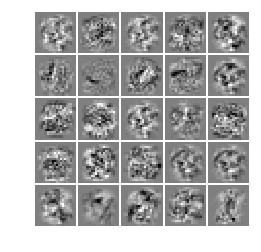

In [29]:
print('Visualizing Neural Network...')

display_data(new_theta1[:,1:])

## Predict

In [30]:
def predict(theta1, theta2, x):
    m = x.shape[0]
    num_labels = theta2.shape[0]
    p = np.zeros((m, 1))
    
    # Add intercept term
    x = np.append(np.ones((m, 1)), x, axis=1)
    # Do sigmoid of dot prod between input & theta 1
    t = sigmoid(x@theta1.T)
    
    # Add hidden layer back in
    t = np.append(np.ones((t.shape[0], 1)), t, axis=1)
    # Do sigmoid of dot prod between theta 1 & theta 2
    t2 = sigmoid(t@theta2.T)
    
    # Return output h
    return np.argmax(t2, axis=1) + 1

pred = predict(new_theta1, new_theta2, orig_X)
#np.set_printoptions(threshold=np.inf)
acc = np.mean(pred == orig_Y.ravel())*100
print('Training Set Accuracy: {}'.format(acc))

Training Set Accuracy: 98.9
